# <center>Определение порядка авторегрессии</center>

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Алгоритм построения модели SARIMA рассмотрим на примере данных об объемах пассажирских авиаперевозок.

In [2]:
passengers = pd.read_csv('C:/Users/mag/passengers.csv', index_col=0, parse_dates=True)

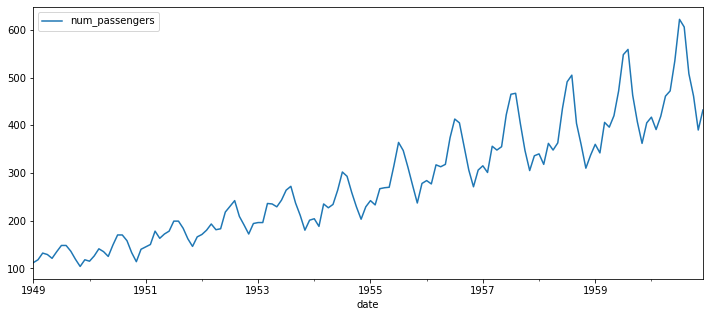

In [4]:
passengers.plot(figsize=(12,5))
plt.show()

Как было отмечено ранее, представленный временной ряд не является стационарным. В нем наблюдаются как тренд, так и сезонность. Кроме того, дисперсия на разных участках ряда не постоянна. Поэтому сначала выполним преобразование Бокса-Кокса.

## 1. Автокорреляция и частичная автокорреляция

Согласно теореме Вольда стационарный ряд можно описать моделью ARMA. Возникает вопрос: как определить порядок авторегрессии и порядок скользящего среднего? Для начала исходный ряд приводят к стационарному. После чего для определения порядка скользящего среднего прибегают к анализу коррелограммы полученного ряда.

In [5]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

In [80]:
passengers_transformed, lmbda = boxcox(passengers['num_passengers'])
y_transformation = pd.DataFrame(passengers['num_passengers'].values, columns=['initial'])
y_transformation['transformed'] = passengers_transformed
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

In [81]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(y_transformation['initial'])[1])
print("После преобразования Бокса-Кокса: p=%f" % adfuller(y_transformation['transformed'])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(y_transformation['seasonal_diff'].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.991880
После преобразования Бокса-Кокса: p=0.617162
После сезонного дифференцирования: p=0.052505
После дополнительного дифференцирования: p=0.000304


Рассмотрим коррелограмму полученного ряда.

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

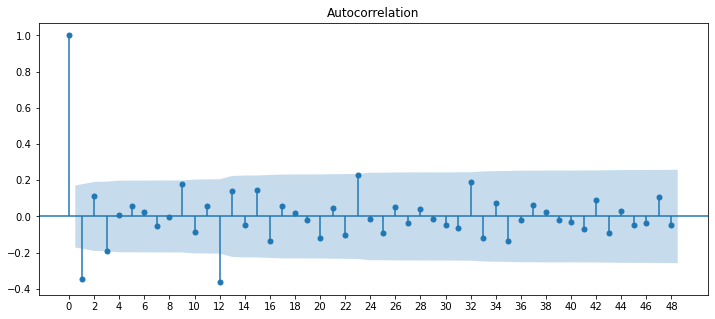

In [9]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

В качестве начального приближения гиперпараметра $q$ берется последний значимый лаг автокорреляции. Для примера выше последний значимый лаг равен 1. При лаге равном 2 значение автокорреляции попадает внутрь голубого "коридора", поэтому дальнейшие значения автокорреляции не рассматриваются, $q_0=1$.

Аналогичным образом определяется начальное приближение для сезонного порядка скользящего среднего $Q$. Необходимо определить последний значимый сезонный лаг автокорреляции. На графике выше последним значимым лагом является 12 (один сезонный период). Соответственно, порядок $Q_0=1$.

**Замечание по терминологии**: гиперпараметрами модели называют те параметры, которые задаются пользователем. Параметрами же называют подобранные путем минимизации функционала качества моделью коэффициенты. Функционалом качества может выступать, например, среднеквадратичная ошибка.

Т.е. когда речь идет о модели $ARIMA(p,d,q)$, гиперпараметрами являются $p$, $d$ и $q$, которые задаются вручную. Параметрами при этом являются коэффициенты $\alpha$, $\phi$ и $\theta$.

Для выбора начального приближения порядка авторегрессии $p$ прибегают к аналогичному методу, но рассматривают частичную автокорреляцию. Частичная автокорреляция &ndash; это автокорреляция после снятия авторегрессии предыдущего порядка. Для определения значения частичной автокорреляции с лагом 2 необходимо построить авторегрессию порядка 1 ($AR(1)$), вычесть эту авторегрессию из ряда и вычислить автокорреляцию на полученных остатках, т.е.:
$$\phi_{hh}=\begin{cases} r(y_{t+1},y_t), & h=1, \\ 
r(y_{t+h}-y_{t+h}^{h-1},y_t-y_t^{h-1}), & h\ge1, \end{cases}$$
где $y_t^{h-1} -$ авторегрессии следующего вида:
$$y_t^{h-1}=\beta_1 y_{t+1}+\beta_2 y_{t+2}+...+\beta_{h-1} y_{t+h-1},$$
$$y_{t+h}^{h-1}=\beta_1 y_{t+h-1}+\beta_2 y_{t+h-2}+...+\beta_{h-1} y_{t+1}.$$

Для построения графика частичной автокорреляции служит функция `plot_pacf`, которая находится в том же модуле `statsmodels.graphics.tsaplots`.

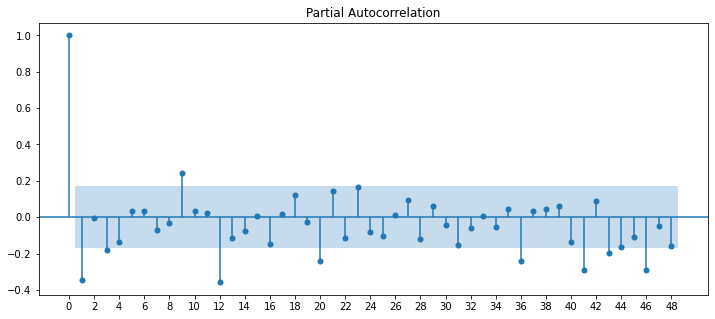

In [10]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Последний значимый лаг также равен 1, соответственно, $p_0=1$. При лаге 24 автокорреляцию можно считать значимой, однако слишком высокий порядок авторегрессии выбирать не рекомендуется. Возьмем $P_0=1$.

Для выбора оптимальных значений гиперпараметров $p$, $q$, $P$ и $Q$ необходимо построить соответствующие модели авторегрессии и оценить их качество. Поскольку вариантов достаточно много, обычно рассматриваются гиперпараметры в окрестности начального приближения  $p_0$, $q_0$, $P_0$, $Q_0$.

In [11]:
p = range(0, 3)
q = range(0, 3)
P = range(0, 2)
Q = range(0, 2)
d = 1

In [12]:
from itertools import product

In [13]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

36

Получили 36 возможных наборов гиперпараметров. Гиперпараметры модели нельзя выбирать методом максимального правдоподобия, поскольку с увеличением количества параметров значение функции правдоподобия $L$ растет. 

Поэтому для сравнения различных моделей применяется информационный критерий Акаике:
$$AIC=-2L+2k,$$
где $k$ &ndash; число параметров модели. Чем меньше значение данного критерия, тем лучше.

## 2. Построение модели SARIMA

Модель SARIMA можно найти в модуле `statsmodels.tsa.statespace.sarimax`. Процесс обучения модели (настройки параметров модели) аналогичен процессу обучения адаптивных методов.

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Обучим модель `SARIMA(1,1,0),(1,1,1)`. В качестве первого аргумента функции `SARIMAX` необходимо передать временной ряд. Чтобы определить порядки авторегрессии, дифференцирования и скользящего среднего необходимо передать их в виде кортежа в аргумент `order`. В данном случае передадим временной ряд, полученный после сезонного дифференцирования, поскольку обычное дифференцирование функция произведет самостоятельно.

In [82]:
model = SARIMAX(y_transformation['initial'], 
                order=(1, 1, 0), 
                seasonal_order=(1, 1, 1, 12)).fit()

Значение критерия Акаике:

In [83]:
model.aic

1020.4927998853238

Прогноз модели также можно получить с помощью функций `forecast` и `predict`.

In [84]:
model.params

ar.L1        -0.322589
ar.S.L12     -0.890945
ma.S.L12      0.791264
sigma2      131.525051
dtype: float64

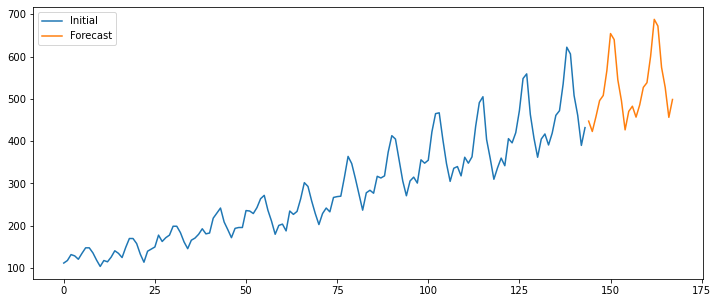

In [85]:
y_transformation['initial'].plot(figsize=(12,5))
model.forecast(24).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()

<div class="alert alert-info">

<h3> Задание 1</h3>
<p></p>
<ol>
<li>Среди ранее полученных наборов гиперпараметров (<b>parameters_list</b>) найдите тот, для которого критерий Акаике минимален.</li>
    <p></p>
<li>С помощью функции <b>predict</b> получите прогноз на 36 точек вперед и отобразите его на графике.</li>
    <p></p>
</ol>
</div>

<p></p>
</div>

In [86]:
parameters_list

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 1),
 (1, 2, 0, 0),
 (1, 2, 0, 1),
 (1, 2, 1, 0),
 (1, 2, 1, 1),
 (2, 0, 0, 0),
 (2, 0, 0, 1),
 (2, 0, 1, 0),
 (2, 0, 1, 1),
 (2, 1, 0, 0),
 (2, 1, 0, 1),
 (2, 1, 1, 0),
 (2, 1, 1, 1),
 (2, 2, 0, 0),
 (2, 2, 0, 1),
 (2, 2, 1, 0),
 (2, 2, 1, 1)]

In [87]:
minn = 10000;

for i in parameters_list:
    model = SARIMAX(y_transformation['initial'], 
    order = (i[0], 1, i[1]), seasonal_order=(i[2], 1, i[3], 12)).fit()
    if model.aic < minn:
        minn = model.aic;
        minn1 = i;
print (minn, minn1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1017.8467850044904 (2, 1, 0, 0)


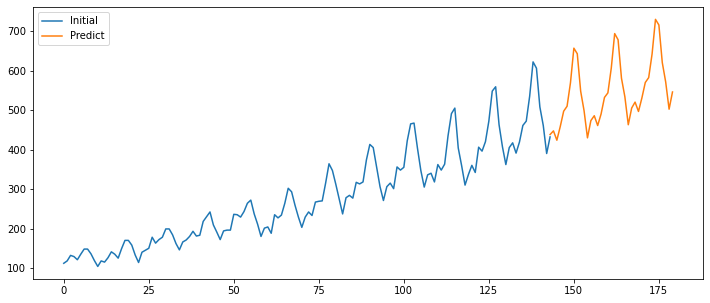

In [88]:
y_transformation['initial'].plot(figsize=(12,5))
model.predict(start = y_transformation['initial'].index[-1], end = y_transformation['initial'].index[-1] + 36).plot()
plt.legend(['Initial', 'Predict'])
plt.show()

In [63]:
df = pd.read_csv('C:/Users/mag/monthly-australian-wine-sales.csv', index_col=0, parse_dates=True)
df.head()

,sales
month,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


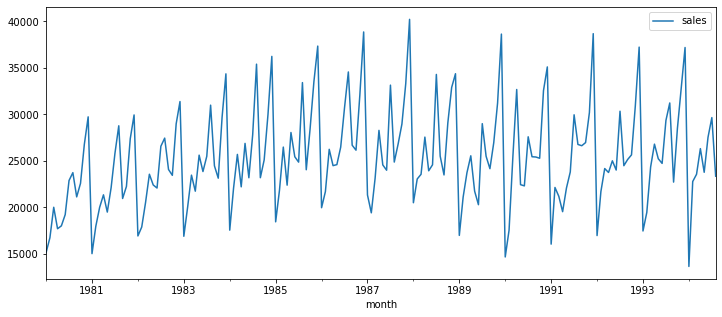

In [64]:
df.plot(figsize=(12,5))
plt.show()

In [71]:
passengers_transformed, lmbda = boxcox(df['sales'])
y_transformation1 = pd.DataFrame(df['sales'].values, columns=['initial'])
y_transformation1['transformed'] = passengers_transformed
y_transformation1['seasonal_diff'] = y_transformation1['transformed'].diff(12)
y_transformation1['lag1_diff'] = y_transformation1['seasonal_diff'].diff(1)

In [72]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(y_transformation['initial'])[1])
print("После преобразования Бокса-Кокса: p=%f" % adfuller(y_transformation['transformed'])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(y_transformation['seasonal_diff'].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.051161
После преобразования Бокса-Кокса: p=0.029565
После сезонного дифференцирования: p=0.128317
После дополнительного дифференцирования: p=0.000002


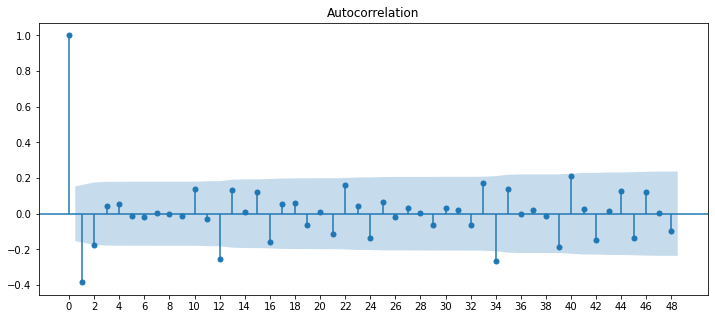

In [67]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

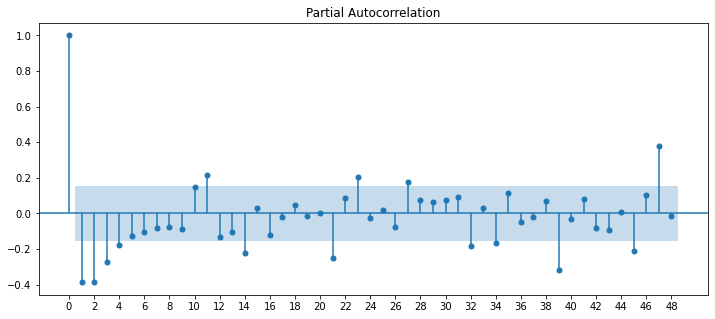

In [68]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

In [91]:
p1 = range(0, 3)
q1 = range(0, 3)
P1 = range(0, 2)
Q1 = range(0, 2)
d1 = 1

In [92]:
parameters1 = product(p1, q1, P1, Q1)
parameters_list1 = list(parameters1)
len(parameters_list1)

36

In [93]:
minn = 10000;

for i in parameters_list:
    model = SARIMAX(y_transformation1['initial'], 
    order = (i[0], 1, i[1]), seasonal_order=(i[2], 1, i[3], 12)).fit()
    if model.aic < minn:
        minn = model.aic;
        minn1 = i;
print (minn, minn1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


3065.5328117194867 (0, 2, 0, 1)


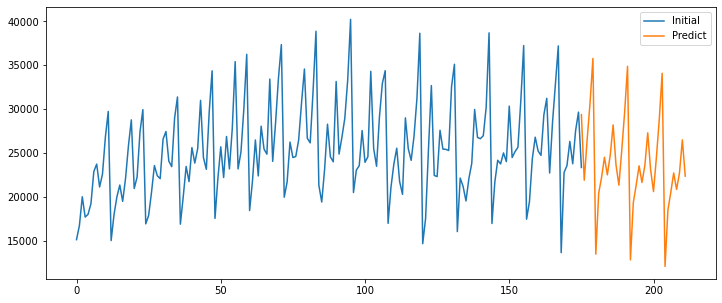

In [95]:
y_transformation1['initial'].plot(figsize=(12,5))
model.predict(start = y_transformation1['initial'].index[-1], end = y_transformation1['initial'].index[-1] + 36).plot()
plt.legend(['Initial', 'Predict'])
plt.show()